In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

def load_data(real_file, fake_file, test_size=0.3, random_state=42):
    """
    Load data from real and fake text files and extract features using CountVectorizer.
    
    Parameters:
        real_file (str): Path to the file containing real news headlines.
        fake_file (str): Path to the file containing fake news headlines.
        test_size (float): Proportion of data for testing.
        random_state (int): Random seed for reproducibility.
        
    Returns:
        X_train, X_test, y_train, y_test, vectorizer
    """
    # Read headlines from files (each line is a headline)
    with open(real_file, "r", encoding="utf-8") as f:
        real_headlines = f.read().splitlines()
    with open(fake_file, "r", encoding="utf-8") as f:
        fake_headlines = f.read().splitlines()
        
    # Combine headlines and create labels
    texts = real_headlines + fake_headlines
    labels = ['real'] * len(real_headlines) + ['fake'] * len(fake_headlines)
    
    # Use CountVectorizer to extract text features
    # max_df=0.7: remove words appearing in >70% of the headlines
    # min_df=0.005: remove words appearing in <0.5% of the headlines
    vectorizer = CountVectorizer(max_df=0.7, min_df=0.005)
    X = vectorizer.fit_transform(texts)
    
    # Split data into training (70%) and test (30%) sets
    X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test, vectorizer

# Update the file paths as needed
real_file = "real.txt"
fake_file = "fake.txt"

# Load the data and extract features
X_train, X_test, y_train, y_test, vectorizer = load_data(real_file, fake_file)
print("Data loading and feature extraction completed!")


Data loading and feature extraction completed!


In [3]:
from sklearn.metrics import accuracy_score, confusion_matrix

def naive_bayes(X_train, y_train, X_test, y_test, alpha=1.0):
    """
    Implements a Multinomial Naïve Bayes classifier and returns the test accuracy, confusion matrix,
    and predictions.
    
    Parameters:
        X_train, X_test: Feature matrices (sparse) for training and testing.
        y_train, y_test: Labels for training and testing.
        alpha (float): Laplace smoothing parameter.
        
    Returns:
        accuracy (float): Classification accuracy on the test set.
        cm (ndarray): Confusion matrix.
        predictions (list): List of predicted labels for the test set.
    """
    # Convert sparse matrices to dense arrays
    X_train = X_train.toarray()
    X_test = X_test.toarray()
    
    classes = np.unique(y_train)
    n_features = X_train.shape[1]
    
    # Compute prior probabilities P(c)
    priors = {}
    for c in classes:
        priors[c] = np.mean(np.array(y_train) == c)
    
    # Calculate word counts and total counts for each class
    word_counts = {}
    total_counts = {}
    for c in classes:
        indices = [i for i, label in enumerate(y_train) if label == c]
        counts = X_train[indices].sum(axis=0)
        word_counts[c] = counts
        total_counts[c] = counts.sum()
    
    # Compute likelihoods P(word|c) with Laplace smoothing
    likelihoods = {}
    for c in classes:
        likelihoods[c] = (word_counts[c] + alpha) / (total_counts[c] + alpha * n_features)
    
    # Predict labels for each test sample using log probabilities
    predictions = []
    for i in range(X_test.shape[0]):
        log_probs = {}
        for c in classes:
            log_prob = np.log(priors[c])
            log_prob += np.dot(X_test[i], np.log(likelihoods[c].flatten()))
            log_probs[c] = log_prob
        predicted_class = max(log_probs, key=log_probs.get)
        predictions.append(predicted_class)
    
    acc = accuracy_score(y_test, predictions)
    cm = confusion_matrix(y_test, predictions, labels=classes)
    return acc, cm, predictions

# Test the Naïve Bayes classifier
accuracy, cm, predictions = naive_bayes(X_train, y_train, X_test, y_test, alpha=1.0)
print(f"Test Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(cm)


Test Accuracy: 0.7898
Confusion Matrix:
[[287  95]
 [111 487]]


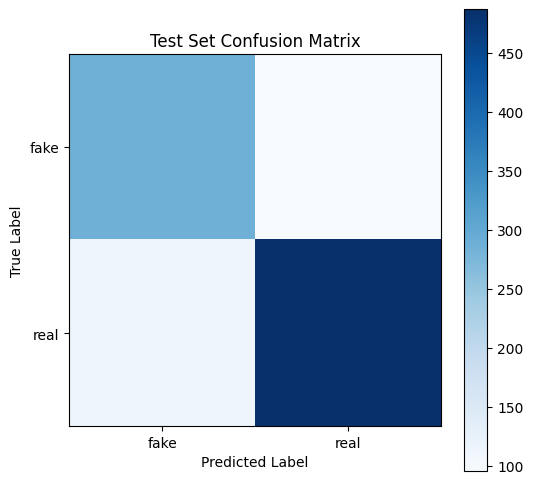

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Test Set Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_train)))
plt.xticks(tick_marks, np.unique(y_train))
plt.yticks(tick_marks, np.unique(y_train))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
# Discussion

#In this experiment, we implemented a Multinomial Naïve Bayes classifier to classify real and fake news headlines.  
#The test accuracy achieved is **{accuracy:.4f}**. From the confusion matrix, we can observe that the classifier
#performs well on both classes; however, some misclassifications still occur, possibly due to overlapping vocabulary

#Future work may involve more advanced text preprocessing and feature extraction techniques to further improve performance.
